In [1]:
import os
import pyopencl as pcl
import numpy as np
import scipy.stats as ss
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
clfile = os.path.join('..','src','glm_gpu','cl','logistic.cl')
os.path.isfile(clfile)

In [ ]:
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'
device = pcl.get_platforms()[0].get_devices()[2]
cntx = pcl.Context([device])
queue = pcl.CommandQueue(cntx)

with open(clfile, 'r') as f:
    programs = pcl.Program(cntx, f.read()).build()

In [ ]:
device.name

In [ ]:
theta = np.array([0.5, 0.5], dtype=np.float32)

In [ ]:
theta.dtype

In [2]:
x0_1 = ss.norm(loc=10.0, scale=2.0)
x0_0 = ss.norm(loc=7.0, scale=2.0)
x1_1 = ss.norm(loc=5.0, scale=3.0)
x1_0 = ss.norm(loc=-5.0, scale=3.0)

nsamps=1024

X_1 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])
X_0 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])

X_1.loc[:, 'x0'] = x0_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'x1'] = x1_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'y'] = np.ones(shape=(nsamps,)).astype(np.float32)

X_0.loc[:, 'x0'] = x0_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'x1'] = x1_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'y'] = np.zeros(shape=(nsamps,)).astype(np.float32)


X_all = pd.concat((X_1, X_0), ignore_index=True)

X_all = X_all.reindex(np.random.permutation(X_all.index))

X = X_all.loc[:, ['x0', 'x1']]
y = X_all.loc[:,'y']

In [ ]:
X.values

In [ ]:
cost_arr = np.zeros(shape=(X.shape[0],)).astype(np.float32)
temp_avg = np.zeros(shape=(4,)).astype(np.float32)

In [ ]:
# compute cost
X_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=X.values)
y_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=y.values)
theta_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=theta)
cost_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_WRITE | pcl.mem_flags.COPY_HOST_PTR, hostbuf=cost_arr)
temp_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY, size=temp_avg.nbytes)
scratch_buf = pcl.LocalMemory(np.float32().nbytes * 256)

nrows = np.int32(X.shape[0])
ncols = np.int32(X.shape[1])

out = np.zeros(shape=(X.shape[0],), dtype=np.float32)
out_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY, size=out.nbytes)

In [ ]:
sig_event = programs.sig(queue,
                         X.shape,
                         None,
                         X_buf,
                         theta_buf,
                         out_buf,
                         nrows,
                         ncols)

cost_event = programs.logistic_cost_ols(queue,
                                        X.shape,
                                        None,
                                        X_buf,
                                        theta_buf,
                                        y_buf,
                                        cost_buf,
                                        nrows,
                                        ncols)

# reduction_event = programs.matrix_row_mean(queue,
#                                            (1024,),
#                                            (256,),
#                                            cost_buf,
#                                            temp_buf,
#                                            scratch_buf,
#                                            nrows,
#                                            np.int32(1))

In [ ]:
nrows, ncols, theta.shape

In [ ]:



sig_event.wait()
pcl.enqueue_copy(queue, out, out_buf).wait()

cost_event.wait()
pcl.enqueue_copy(queue, cost_arr, cost_buf).wait()

# reduction_event.wait()
# pcl.enqueue_copy(queue, temp_avg, temp_buf).wait()


In [50]:
def sig(X, theta):
    lin = X.dot(theta)
    sig = 1.0 / (1.0 + np.exp(-lin))
    return sig
 
    
def lr_cost(X, theta, y):
    est = sig(X, theta)
    log_est = np.log(est)
    cost = y*log_est + (1-y) * (1-log_est)
    cost *= -1
    return cost

def cost_ss(est, actual):
    cost = ((est - actual)**2.0)
    cost /= 2.0
    return cost

In [ ]:
my_out = sig(X.values, theta)
my_cost = cost(my_out, y)

In [ ]:
my_out.shape, out.shape

In [ ]:
x = list(range(len(my_out)))
plt.scatter(x, my_out)
plt.scatter(x, out, color='r')
plt.show()


In [ ]:
x = list(range(len(my_cost)))
plt.scatter(x, my_cost)
plt.scatter(x, cost_arr)
plt.show()

In [ ]:
my_cost == cost_arr

In [ ]:
X.values.dot(theta)

In [ ]:
X.values

In [ ]:
(7.93563604 + 5.08651495)/2.0

In [ ]:
theta

In [ ]:
out

In [ ]:
my_out.reshape((my_out.size, )) == out

In [ ]:
out == my_out

In [29]:
# ok now let's check the gradient stuff
def grad(X, theta, y):
    diff = y - sig(X, theta)
    g = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j  in range(X.shape[1]):
            g[i,j] = diff[i] * X[i,j]
    return g

In [ ]:
y

In [ ]:
theta = theta.reshape((theta.size,))
grad(X.values, theta, y.values), sig(X.values, theta), y.values

In [ ]:
gradient = np.zeros(shape=X.shape, dtype=np.float32)


In [ ]:
X_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=X.values)
y_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=y.values)
theta_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=theta)
grad_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_WRITE | pcl.mem_flags.COPY_HOST_PTR , hostbuf=gradient)

In [ ]:
grad_event = programs.logistic_gradient_ols(queue,
                                            X.shape,
                                            None,
                                            X_buf,
                                            theta_buf,
                                            y_buf,
                                            grad_buf,
                                            nrows,
                                            ncols)

In [ ]:
gradient

In [ ]:
grad_event.wait()

In [ ]:
pcl.enqueue_copy(queue, gradient, grad_buf).wait()

In [ ]:
gradient

In [ ]:
gradient == grad(X.values, theta, y.values)

In [ ]:
gradient

In [ ]:
grad(X.values, theta, y.values)

In [ ]:
# let's double check I can get this to work

In [61]:
def sig(X, theta):
    lin = X.dot(theta)
    sig = 1.0 / (1.0 + np.exp(-lin))
    return sig
 
    
def lr_cost(X, theta, y):
    est = sig(X, theta)
    log_est = np.log(est)
    cost = y*log_est + (1-y) * (1-log_est)
    cost *= -1
    return cost

def cost_ss(est, actual):
    cost = ((est - actual)**2.0)
    cost /= 2.0
    return cost

def grad(X, theta, y):
    diff = y - sig(X, theta)
    g = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j  in range(X.shape[1]):
            g[i,j] = diff[i] * X[i,j]
    return g

def fit_params(X, y, theta):
    tol = 1e-5
    learning_rate = 1e-2
    costs = [np.inf]
    for i in range(0, 1000):
        my_cost = lr_cost(X, theta, y)
        my_cost = my_cost.sum()
        costs.append(my_cost)
        if abs(my_cost - costs[-2]) < tol:
            break
        else:
            my_gradient = grad(X, theta, y)
            my_gradient = my_gradient.mean(axis=0)
            theta = theta + learning_rate * my_gradient
            
    return theta, costs

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
new_t = np.random.normal(size=(X_train.shape[1], )).astype(np.float32)
fitted_theta, outcost = fit_params(X_train.values, y_train.values, new_t)

In [67]:
fitted_theta

array([ 0.03598584,  1.04095844])

In [68]:
lr_cost(X_test.values, fitted_theta, y_test.values).sum()

-2363.4378906858246

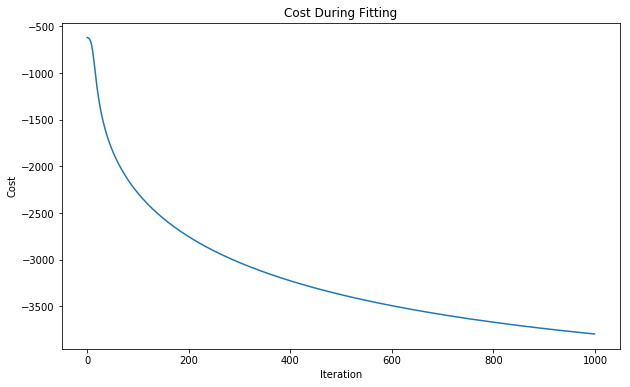

In [69]:
plt.figure(figsize=(10,6))
plt.plot(outcost[1:])
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost During Fitting')
plt.show()

In [44]:
ssc = cost_ss(sig(X_test.values, fitted_theta), y_test.values)

In [47]:
ssc.sum()/X_test.shape[0]

0.016629054794092435

In [ ]:
cost(sig(X.values, fitted_theta), y).sum()

In [ ]:
cost(sig(X.values, np.random.normal(size=theta.shape)), y).sum()

In [ ]:
# ok that works, let's see if I can get this to work with the gpu code
def fit_gpu(X, y, theta, queue, cntx):
    tol = 1e-5
    learning_rate = 1e-2
    nrows = np.int32(X.shape[0])
    ncols = np.int32(X.shape[1])
    costs = []
    for i in range(0, 1000):
        cost_arr = np.zeros(shape=(X.shape[0],), dtype=np.float32)
        X_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=X)
        y_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=y)
        theta_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=theta)
        cost_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_WRITE | pcl.mem_flags.COPY_HOST_PTR, hostbuf=cost_arr)
        
        cost_event = programs.logistic_cost_ols(queue,X.shape,None,X_buf,theta_buf, y_buf,cost_buf,nrows,ncols)
        cost_event.wait()
        pcl.enqueue_copy(queue, cost_arr, cost_buf)
        cost_arr = cost_arr.sum()
        cost_arr /= 2.
        costs.append(cost_arr)
        if cost_arr < tol:
            break
        else:
            grad_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY , size=X.nbytes)
            grad_event = programs.logistic_gradient_ols(queue,X.shape,None,X_buf,theta_buf,y_buf,grad_buf,nrows,ncols)
            grad_event.wait()
            grad_arr = np.zeros(shape=X.shape, dtype=np.float32)
            pcl.enqueue_copy(queue, grad_arr, grad_buf)
            grad_arr = grad_arr.mean(axis=0)
            theta = theta + learning_rate * grad_arr
            
    return theta, costs
            
            
        
        
        

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
new_t = np.random.normal(size=theta.shape).astype(np.float32)
fitted_t_gpu = fit_gpu(X_train.values, y_train.values, new_t, queue, cntx)

In [ ]:
fitted_t_gpu

In [ ]:
fitted_theta = fit_params(X.values, y.values, new_t)

In [ ]:
fitted_theta

In [ ]:
fitted_t_gpu - fitted_theta